### Importando las bibliotecas necesarias

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, levene,bartlett, ttest_ind, mannwhitneyu, kruskal,chi2_contingency,f_oneway
from pingouin import welch_anova
import scipy.stats as stats
from trial import simulate_trial
import random

c:\Users\Ricardo Capiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definiendo los tests con los que se trabajarán 

In [2]:
def verify_suppositions(groups):
    #Analizar si todos los grupos siguen una distribucion normal
    normality = True
    var_homo = True
    for group in groups:
        # Prueba de normalidad (Shapiro-Wilk)
        stat, p_value = shapiro(group)
        print(f'Shapiro-Wilk test: p-value = {p_value}')
        # Si el p-valor es mayor que 0.05, los datos son normales
        if p_value <= 0.05:
            print('Los datos no siguen una distribución normal')
            normality = False
            break
    if normality:
        print('Los datos siguen una distribución normal')
        #Si los datos siguen una distribución normal aplicarv Test de Bartlett
        
        # Prueba de Bartlett
        stat, p_value = bartlett(*groups)

        print(f"Estadístico de Bartlett: {stat}")
        print(f"Valor p: {p_value}")

        if p_value < 0.05:
            print("Rechazamos la hipótesis nula: Las varianzas no son homogéneas")
            var_homo = False
        else:
            print("No se rechaza la hipótesis nula: Las varianzas son homogéneas")
            var_homo = True

    else:
        #Si no se puede asegurar que los datos siguen una distribución normal, aplicar test de Levene
        stat, p_value = levene(*groups)
        print(f'Levene test: p-value = {p_value}')
        # Si el p-valor es mayor que 0.05, se asume homogeneidad de varianzas
        if p_value > 0.05:
            print('Hay homegeneidad de varianza')
            var_homo = True
        else:
            print('No hay homegeneidad de varianza')
            var_homo = False
    return normality, var_homo
    


In [3]:
def multiple_groups_test(groups):

    normality, var_homo = verify_suppositions(groups)
    if not normality:
        # Prueba de Kruskal-Wallis
        stat, p_value = kruskal(*groups)

        print(f"Estadístico: {stat}, Valor p: {p_value}")
        if p_value < 0.05:
            print("Rechazamos la hipótesis nula: Al menos uno de los grupos es diferente.")
            return True
        else:
            print("No se rechaza la hipótesis nula: Los grupos no son significativamente diferentes.")
            return False

    elif normality and var_homo:
        #Se cumplen las suposiciones, por tanto es posible aplicar Test de ANOVA
        # Aplicar ANOVA de una vía
        anova_result = f_oneway(*groups)

        print(f'Estadístico F: {anova_result.statistic}')
        print(f'Valor p: {anova_result.pvalue}')
        if anova_result.pvalue < 0.05:
            print('Hay diferencias significativas entre los grupos')
            return True
        else:
            print('No hay diferencias significativas entre los grupos')
            return False
    else:
        # #Aplicar ANOVA de Welch
        # modelo = ols('valor ~ C(grupo)', data=groups).fit()

        # # ANOVA de Welch: usamos el argumento `robust='hc3'` para ajustar por varianzas desiguales
        # # anova_result = sm.stats.anova_lm(modelo, typ=2, robust='hc3')
        # if p_value < 0.05:
        #     print("Existen diferencias significativas entre los grupos")
#     return True
        # Si no se cumple la homogeneidad de varianzas, aplicar ANOVA de Welch
        data = {'values': [], 'groups': []}
        for i, group in enumerate(groups):
            data['values'].extend(group)
            data['groups'].extend([i] * len(group))

        # Aplicar ANOVA de Welch usando pingouin
        welch_result = welch_anova(dv='values', between='groups', data=data)

        print(f'Estadístico F: {welch_result["F"].values[0]}')
        print(f'Valor p: {welch_result["p-unc"].values[0]}')
        if welch_result["p-unc"].values[0] < 0.05:
            print('Hay diferencias significativas entre los grupos (ANOVA de Welch)')
            return True
        else:
            print('No hay diferencias significativas entre los grupos (ANOVA de Welch)')
            return False

In [4]:
def two_groups_test(groups):
    normality, var_homo = verify_suppositions(groups)

    if normality and var_homo:
        # Prueba t de Student para muestras independientes
        stat, p_value = ttest_ind(*groups)
        print(f'Prueba t: p-value = {p_value}')

        # Si el p-valor es menor que 0.05, hay diferencias significativas entre los dos grupos
        if p_value < 0.05:
            print('Hay diferencias significativas entre los grupos')
            return True
        else:
            print('No hay diferencias significativas entre los grupos')
            return False
    else:
        # Prueba Mann-Whitney U
        stat, p_value = mannwhitneyu(*groups)
        print(f'Mann-Whitney U test: p-value = {p_value}')

        # Si el p-valor es menor que 0.05, hay diferencias significativas entre los dos grupos
        if p_value < 0.05:
            print('Hay diferencias significativas entre los grupos')
            return True
        else:
            print('No hay diferencias significativas entre los grupos')
            return False

In [5]:
import numpy as np

def chi2_test(groups):
    """
    Prueba Chi Cuadrado para comparar proporciones
    """
    chi2, p, dof, expected = chi2_contingency(groups)

    print(f"Estadístico Chi-cuadrado: {chi2}")
    print(f"Valor p: {p}")

    if p < 0.05:
        print("Rechazamos la hipótesis nula: Hay una diferencia significativa entre los grupos.")
        return True
    else:
        print("No se rechaza la hipótesis nula: No hay diferencias significativas entre los grupos.")
        return False


### Preparando los datos

In [6]:
from utils import Fact, Fact_Types, Fact_Info, map_trait_level, Roles
from witness import Witness, perceive_world_witness, execute_actions_witness
from lawyer import Lawyer, perceive_world_lawyer
from juror import Rule1, Rule5, Rule6, Rule4, Rule2, Rule3, Rule7, Rule8, Rule9, Rule10, Rule11, Rule12, Rule13, Rule14, Rule15, Juror, perceive_world_juror, execute_actions_juror, JurorBeliefs 
from agent_methods import vote

case = {Fact(Fact_Types.oportunity, "Vio al sospechoso cerca de la escena") : Fact_Info(0,0),
        Fact(Fact_Types.motive, "El acusado tenía razones para estar molesto") : Fact_Info(0,0),
        Fact(Fact_Types.character, "El acusado es conocido por su honestidad") : Fact_Info(0,0),
        Fact(Fact_Types.oportunity, "No recuerda exactamente la hora del incidente") : Fact_Info(0,0),
        Fact(Fact_Types.motive, "El acusado tuvo una discusión con la víctima") : Fact_Info(0,0),
        Fact(Fact_Types.character, "El acusado tiene un carácter violento") : Fact_Info(0,0),
        Fact(Fact_Types.oportunity, "El acusado estaba cerca del lugar del crimen") : Fact_Info(0,0),
        Fact(Fact_Types.motive, "El acusado había perdido su trabajo"): Fact_Info(0,0)}
items_case = list(case.keys()) 

witness1 = Witness(1, perceive_world_witness, execute_actions_witness, facts=items_case[:3], age=35, socioeconomic_status="medio", education="high", ineptitude='low', side=True)
witness2 = Witness(2, perceive_world_witness, execute_actions_witness, facts=items_case[3:5], age=50, socioeconomic_status="alto", education="medium", ineptitude='middle', side=True)
witness3 = Witness(3, perceive_world_witness, execute_actions_witness, facts=items_case[5:], age=29, socioeconomic_status="bajo", education="low", ineptitude='high', side=False)

witnesses = [witness1, witness2, witness3]
testimonies = [] # testigo, hecho a testificar
for wit in witnesses:
    for fact in wit.facts:
        testimonies.append((wit, fact))

lawyer = Lawyer(perceive_world_lawyer, None, witnesses)
assert_rules = [Rule1, Rule5, Rule6, Rule4]
generate_desires_rules = [Rule2, Rule3, Rule7, Rule8, Rule9, Rule10, Rule11, Rule12, Rule13, Rule14, Rule15]
# jury_pool = generate_jury_pool('data.json', case, assert_rules, generate_desires_rules)
# Creating 6 instances of the juror class
jury1 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 1,map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), "Internal", map_trait_level("High"), map_trait_level("High"), map_trait_level("High"), map_trait_level("Low"), "None", 30, "Male", "Asian", map_trait_level("Middle"),JurorBeliefs(case)) 
jury1.role = Roles.holdout
jury2 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 2, map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), "External", map_trait_level("Low"), map_trait_level("Low"), map_trait_level("Low"), map_trait_level("High"), "Some", 45, "Female", "Caucasian", map_trait_level("High"), JurorBeliefs(case))
jury2.role = Roles.follower
jury3 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 3,map_trait_level("High"), map_trait_level("High"), map_trait_level("Low"), map_trait_level("Low"), map_trait_level("High"), "Internal", map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), "None", 25, "Male", "African American", map_trait_level("Low"),JurorBeliefs(case))
jury3.role = Roles.filler
jury4 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 4, map_trait_level("Low"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("High"), map_trait_level("Low"), "External", map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), "Some", 35, "Female", "Hispanic", map_trait_level("Middle"),JurorBeliefs(case))
jury4.role = Roles.follower
jury5 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 5,map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("High"), map_trait_level("Low"), "Internal", map_trait_level("High"), map_trait_level("High"), map_trait_level("High"), map_trait_level("Low"), "None", 40, "Male", "Asian", map_trait_level("High"),JurorBeliefs(case))
jury5.role = Roles.leader #leader
jury6 = Juror(perceive_world_juror, execute_actions_juror, assert_rules, generate_desires_rules , vote, 6, map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), map_trait_level("High"), map_trait_level("Low"), "External", map_trait_level("Low"), map_trait_level("Low"), map_trait_level("Low"), map_trait_level("High"), "Some", 50, "Female", "Caucasian", map_trait_level("Low"),JurorBeliefs(case))
jury6.role = Roles.follower
jury_pool= [jury1,jury2,jury3,jury4,jury5,jury6]

## Hipótesis:
- **Hipótesis nula (H₀)**
- **Hipótesis alternativa (H₁)**

1. **Comparar el tiempo de deliberación entre juicios por tamaño de jurado**:
    - **H₀**: No hay diferencias en el tiempo de deliberación por tamaño de jurado.
    - **H₁**: Hay diferencias en el tiempo de deliberación por tamaño de jurado.
    - Usar multiple_groups_test

In [7]:
groups_test1 = []
for jury_amount in [2,4,6]: # el rango puede cambiar
    group = []
    for i in range(100):
        n_people = len(jury_pool)
        n_strategies = len(lawyer.strategies[0])
        n_testimonies = len(testimonies)
        jurors_strategies = tuple(random.sample(range(1, n_people+1), jury_amount)) + tuple(np.random.randint(1, n_strategies+1) for _ in range(n_testimonies))
        _, time, _ = simulate_trial(jurors_strategies, jury_amount, testimonies, jury_pool, lawyer, case)
        group.append(time)
    groups_test1.append(group)
anova_test = multiple_groups_test(groups_test1)

c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

Shapiro-Wilk test: p-value = 1.4159248281007015e-12
Los datos no siguen una distribución normal
Levene test: p-value = 4.5741736451607817e-26
No hay homegeneidad de varianza
Estadístico: 97.80383749902397, Valor p: 5.783177640185637e-22
Rechazamos la hipótesis nula: Al menos uno de los grupos es diferente.


c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

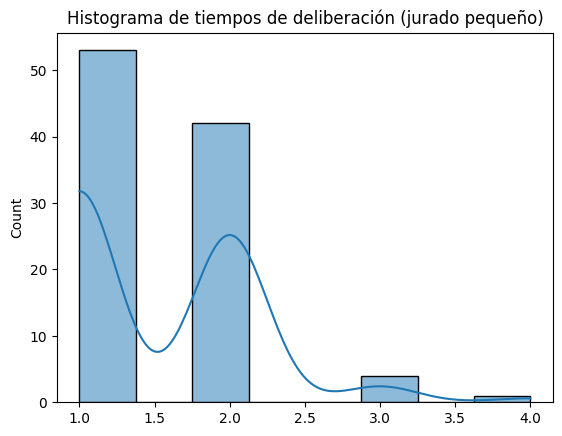

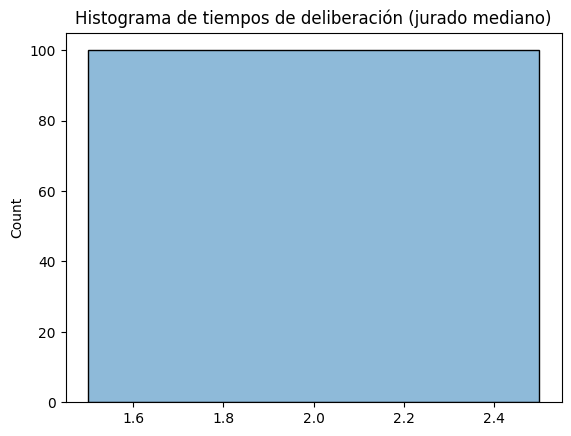

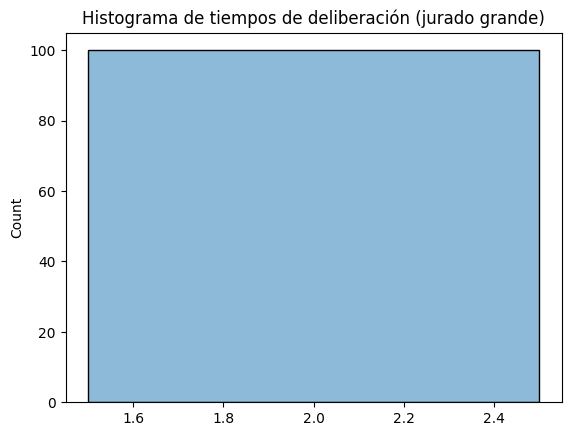

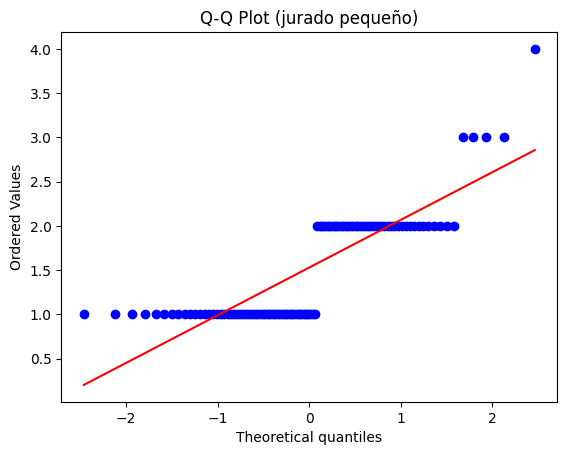

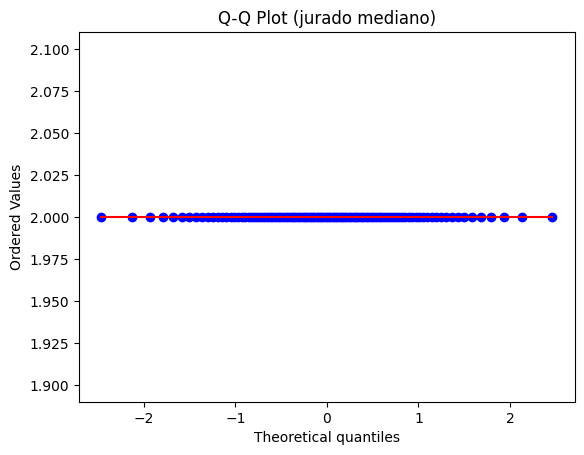

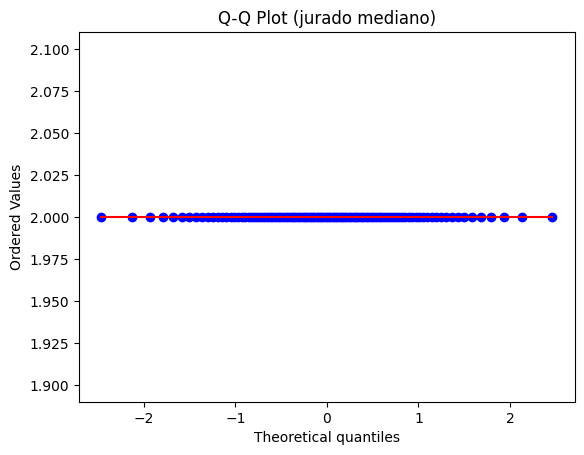

In [8]:
# Histograma
sns.histplot(groups_test1[0], kde=True)
plt.title("Histograma de tiempos de deliberación (jurado pequeño)")
plt.show()

sns.histplot(groups_test1[1], kde=True)
plt.title("Histograma de tiempos de deliberación (jurado mediano)")
plt.show()

sns.histplot(groups_test1[2], kde=True)
plt.title("Histograma de tiempos de deliberación (jurado grande)")
plt.show()


stats.probplot(groups_test1[0], dist="norm", plot=plt)
plt.title("Q-Q Plot (jurado pequeño)")
plt.show()

stats.probplot(groups_test1[1], dist="norm", plot=plt)
plt.title("Q-Q Plot (jurado mediano)")
plt.show()

stats.probplot(groups_test1[2], dist="norm", plot=plt)
plt.title("Q-Q Plot (jurado mediano)")
plt.show()

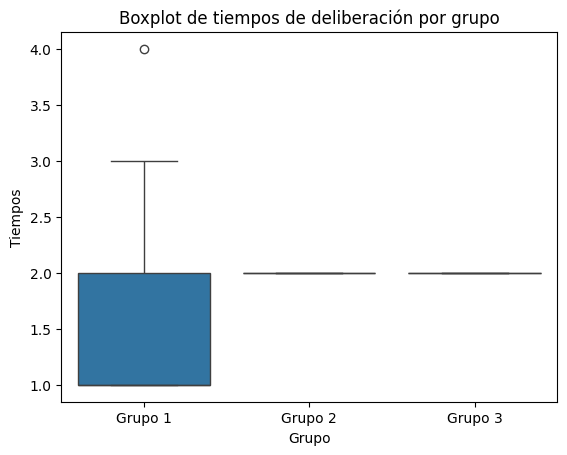

In [9]:
# Boxplot para visualizar las varianzas
datos = {
    "Tiempos": groups_test1[0] + groups_test1[1] + groups_test1[2],
    "Grupo": ["Grupo 1"] * len(groups_test1[0]) + ["Grupo 2"] * len(groups_test1[1]) + ["Grupo 3"] * len(groups_test1[2])
}

sns.boxplot(x="Grupo", y="Tiempos", data=datos)
plt.title("Boxplot de tiempos de deliberación por grupo")
plt.show()

2. **Comparar los tiempos de deliberación de los juicios que llegan a un veredicto con la presencia de un único líder en el jurado vs los que llegan a un veredicto con la presencia de ninguno o más de un  líder**:
    - **H₀**: No hay diferencias en el tiempo de deliberación por la cantidad de líderes.
    - **H₁**: Hay diferencias en el tiempo de deliberación por la cantidad de líderes.
    - Usar two_groups_test

In [10]:
# Compare the time deliberation such that there is a single leader on the jury.
two_groups = []
leaders = [j for j in jury_pool if j.role == Roles.leader]
non_leaders = [j for j in jury_pool if j.role != Roles.leader]
jury_size = 4 # el tamaño puede cambiar 

if len(leaders) > 0:
    for i in range(2):
        group = []
        for _ in range(10):
            if i == 0:
                selected_leaders = [random.choice(leaders)]
                selected_non_leaders = random.sample(non_leaders, jury_size - 1)
            else:
                if len(leaders) < 3:
                    n_selections = 0
                    selected_leaders = []
                    selected_non_leaders = random.sample(non_leaders, jury_size - n_selections)
                elif len(leaders) > 2:    
                    n_selections = random.choice(range(2,min(jury_size, len(leaders))+1))
                    selected_leaders = random.sample(leaders, n_selections)
                    selected_non_leaders = random.sample(non_leaders, jury_size - n_selections)
            
            n_people = len(jury_pool)
            n_strategies = len(lawyer.strategies[0])
            n_testimonies = len(testimonies)
            selected_jury = [j.id for j in selected_leaders] + [j.id for j in selected_non_leaders]
            jurors_strategies = tuple(selected_jury) + tuple(np.random.randint(1, n_strategies+1) for _ in range(n_testimonies))
            _, time, _ = simulate_trial(jurors_strategies, jury_size, testimonies, jury_pool, lawyer, case)
            group.append(time)
        two_groups.append(group)

    t_student_test = two_groups_test(two_groups)
else:
    print('No hay ningún líder para realizar este test')

c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

Shapiro-Wilk test: p-value = 1.0
Shapiro-Wilk test: p-value = 1.0
Los datos siguen una distribución normal
Estadístico de Bartlett: nan
Valor p: nan
No se rechaza la hipótesis nula: Las varianzas son homogéneas
Prueba t: p-value = nan
No hay diferencias significativas entre los grupos


c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

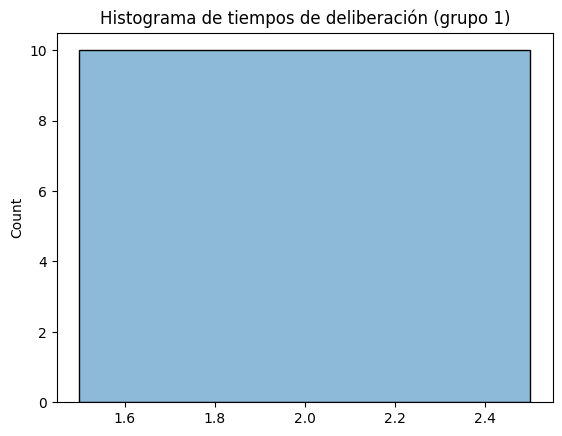

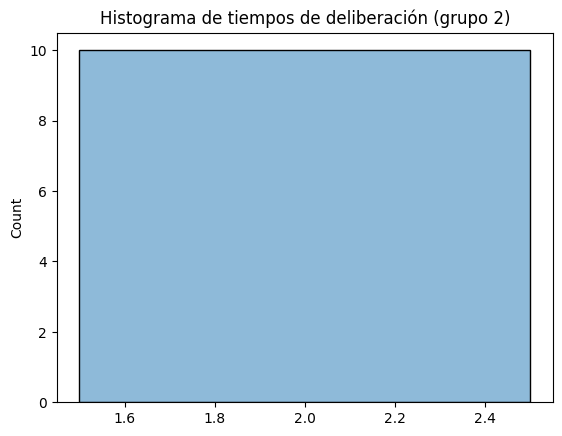

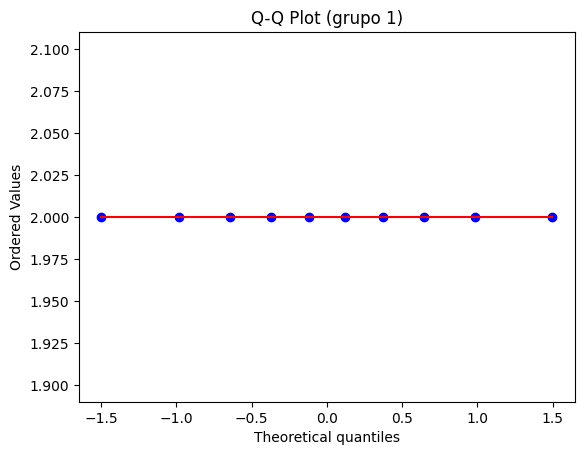

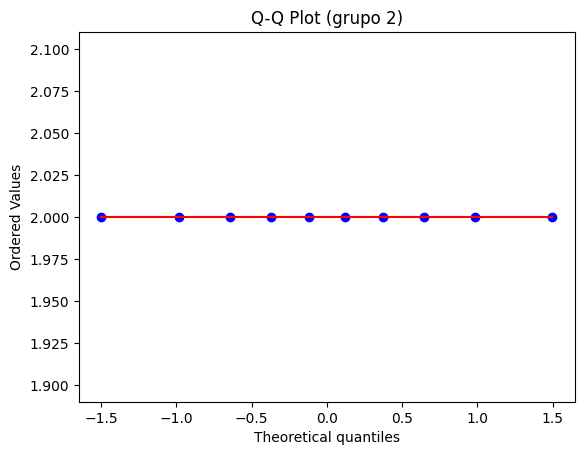

In [11]:
# Histograma
sns.histplot(two_groups[0], kde=True)
plt.title("Histograma de tiempos de deliberación (grupo 1)")
plt.show()

sns.histplot(two_groups[1], kde=True)
plt.title("Histograma de tiempos de deliberación (grupo 2)")
plt.show()

# Q-Q Plot
stats.probplot(two_groups[0], dist="norm", plot=plt)
plt.title("Q-Q Plot (grupo 1)")
plt.show()

# Q-Q Plot
stats.probplot(two_groups[1], dist="norm", plot=plt)
plt.title("Q-Q Plot (grupo 2)")
plt.show()


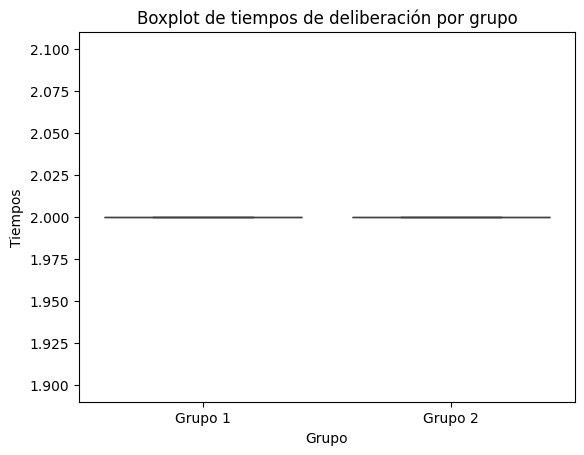

In [12]:
# Boxplot para visualizar las varianzas
datos = {
    "Tiempos": two_groups[0] + two_groups[1],
    "Grupo": ["Grupo 1"] * len(two_groups[0]) + ["Grupo 2"] * len(two_groups[1])
}

sns.boxplot(x="Grupo", y="Tiempos", data=datos)
plt.title("Boxplot de tiempos de deliberación por grupo")
plt.show()

3. **Comparar los juicios que llegan a un veredicto con la presencia de un único líder en el jurado vs los que llegan a un veredicto con la presencia de ninguno o más de un  líder**:
    - **H₀**: Las proporciones de juicios que llegan a un veredicto son iguales en todos los grupos.
    - **H₁**: Hay al menos un grupo donde la proporción de juicios que llegan a un veredicto es significativamente diferente.
    - Usar prueba Chi Cuadrado

In [14]:
veredicts = []
leaders = [j for j in jury_pool if j.role == Roles.leader]
non_leaders = [j for j in jury_pool if j.role != Roles.leader]
jury_size = 4 # el tamaño puede cambiar 

if len(leaders) > 0:
    for i in range(2):
        group = [0,0]
        for _ in range(100):
            if i == 0:
                selected_leaders = [random.choice(leaders)]
                selected_non_leaders = random.sample(non_leaders, jury_size - 1)
            else:
                if len(leaders) < 3:
                    n_selections = 0
                    selected_leaders = []
                    selected_non_leaders = random.sample(non_leaders, jury_size - n_selections)
                elif len(leaders) > 2:    
                    n_selections = random.choice(range(2,min(jury_size, len(leaders))+1))
                    selected_leaders = random.sample(leaders, n_selections)
                    selected_non_leaders = random.sample(non_leaders, jury_size - n_selections)
            
            n_people = len(jury_pool)
            n_strategies = len(lawyer.strategies[0])
            n_testimonies = len(testimonies)
            selected_jury = [j.id for j in selected_leaders] + [j.id for j in selected_non_leaders]
            jurors_strategies = tuple(selected_jury) + tuple(np.random.randint(1, n_strategies+1) for _ in range(n_testimonies))
            no_guilty, _, _ = simulate_trial(jurors_strategies, jury_size, testimonies, jury_pool, lawyer, case)
            if no_guilty == jury_size:
                group[0] += 1
        group[1] = 100 - group[0]
        print(group)
        veredicts.append(group)

    chi2_value = chi2_test(veredicts)
else:
    print('No hay ningún líder para realizar este test')

c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

[100, 0]


c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

[100, 0]


c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_value[fact[0]].relevance * juror.beliefs.facts_with_value[fact[0]].veracity for fact in juror.beliefs.facts_with_value.items()) / total_relevance
c:\Riki\Escuela\Ciencia de la Computacion\3er Anno\Simulacion\Trial_Simulation\Project\Trial_Simulation\agent_methods.py:391: RuntimeWarning: invalid value encountered in scalar divide
  weighted_veracity = sum(juror.beliefs.facts_with_

ValueError: The internally computed table of expected frequencies has a zero element at (0, 1).

In [ ]:
# Histograma
sns.histplot(veredicts[0], kde=True)
plt.title("Histograma de tiempos de deliberación (grupo 1)")
plt.show()

sns.histplot(veredicts[1], kde=True)
plt.title("Histograma de tiempos de deliberación (grupo 2)")
plt.show()

# Q-Q Plot
stats.probplot(veredicts[0], dist="norm", plot=plt)
plt.title("Q-Q Plot (grupo 1)")
plt.show()

# Q-Q Plot
stats.probplot(veredicts[1], dist="norm", plot=plt)
plt.title("Q-Q Plot (grupo 2)")
plt.show()


In [ ]:
# Boxplot para visualizar las varianzas
datos = {
    "Tiempos": veredicts[0] + veredicts[1],
    "Grupo": ["Grupo 1"] * len(veredicts[0]) + ["Grupo 2"] * len(veredicts[1])
}

sns.boxplot(x="Grupo", y="Tiempos", data=datos)
plt.title("Boxplot de tiempos de deliberación por grupo")
plt.show()

**Analizar cantidad de juicios ganados por el abogado**:
- Si se seleccionan las estrategias y el jurado de forma aleatoria
- Si se seleccionan las estrategias y el jurado que mejor resultado dio en el algoritmo genético

In [ ]:
from agent_methods import update_pool
from environment import SimulationContext
from genetic_algorithm import genetic_algorithm

update_pool(jury_pool) 
context = SimulationContext()
context.set_sequence_of_events('')
top_results = genetic_algorithm(lawyer=lawyer, n_jurors=jury_size, jury_pool=jury_pool, testimonies=testimonies)

best_solution = None
best_score = 0
for solution, score, _ in top_results:
    if score > best_score:
        best_score = score
        best_solution = solution

amount_random = 0
for i in range(100):
    n_people = len(jury_pool)
    n_strategies = len(lawyer.strategies[0])
    n_testimonies = len(testimonies)
    jurors_strategies = tuple(random.sample(range(1, n_people+1), jury_size)) + tuple(np.random.randint(1, n_strategies+1) for _ in range(n_testimonies))
    no_guilty, time, _ = simulate_trial(jurors_strategies, jury_size, testimonies, jury_pool, lawyer, case)
    if no_guilty >= (4/5)*jury_size: # el abogado gano el caso si la cantidad de no_guilty son mayor que el 80% 
        amount_random += 1

amount_gen_alg = 0
for i in range(100):
    n_people = len(jury_pool)
    n_strategies = len(lawyer.strategies[0])
    n_testimonies = len(testimonies)
    no_guilty, time, _ = simulate_trial(best_solution, jury_size, testimonies, jury_pool, lawyer, case)
    if no_guilty >= (4/5)*jury_size: # el abogado gano el caso si la cantidad de no_guilty son mayor que el 80%
        amount_gen_alg += 1